### Warning: Running this on your local/personal laptop will be super slow and likely to destroy your battery. 
### Run on on a GPU provided by the CS department instead, after converting this notebook to a python file.

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import PIL

# Define a series of transformations for the training data.
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),  # Randomly flip the images horizontally 50% of the time.
    transforms.RandomAffine(  # Apply random affine transformations to the images.
        degrees=(-5, 5),  # Rotate by degrees between -5 and 5.
        translate=(0.1, 0.1),  # Translate by a fraction of image width/height (10% here).
        scale=(0.9, 1.1),  # Scale images between 90% and 110%.
        resample=PIL.Image.BILINEAR  # Use bilinear interpolation for resampling.
    ),
    transforms.ToTensor(),  # Convert images to PyTorch tensors.
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize tensors with mean and standard deviation.
])

# Define transformations for the test data.
test_transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to PyTorch tensors.
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize tensors with mean and standard deviation.
])

# Load the CIFAR10 dataset for training and apply the above transformations.
dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
# Split the dataset into training and validation sets.
train_set, val_set = torch.utils.data.random_split(dataset, [40000, 10000])

# Create data loaders for the training and validation sets.
train_loader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True, num_workers=8)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=128, shuffle=False, num_workers=8)

# Load the CIFAR10 dataset for testing and apply test transformations.
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=128, shuffle=False, num_workers=8)

# Define the classes in the CIFAR10 dataset.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


/var/folders/lx/cv57zfl536v865_7hwvz7vsh0000gn/T/ipykernel_5487/3558137297.py:8: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  transforms.RandomAffine(degrees=(-5, 5), translate=(0.1, 0.1), scale=(0.9, 1.1), resample=PIL.Image.BILINEAR),
/Users/ashleygao/miniforge3/lib/python3.10/site-packages/torchvision/transforms/transforms.py:1427: UserWarning: The parameter 'resample' is deprecated since 0.12 and will be removed in 0.14. Please use 'interpolation' instead.
  warnings.warn(


Files already downloaded and verified
Files already downloaded and verified


## Visualize image for each class

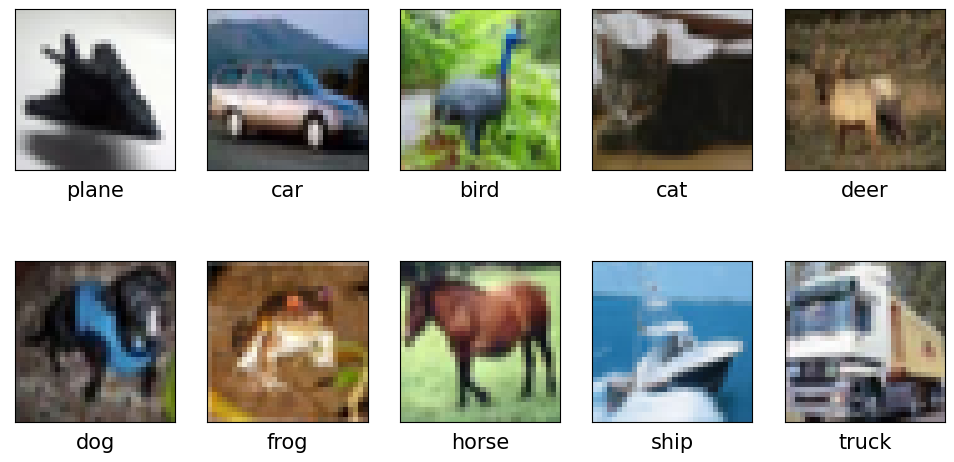

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# visualize training image for each class
sample_images = [dataset.data[np.asarray(dataset.targets) == label][0] for label in range(10)]
# show images
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
i = 0
for row in axes:
    for axis in row:
        axis.set_xticks([])
        axis.set_yticks([])
        axis.set_xlabel(classes[i], fontsize=15)
        axis.imshow(sample_images[i])
        i += 1

## Define CNN architecture

In [3]:
import torch.nn as nn
import torch.nn.functional as F

# Define a neural network class called 'Net' which inherits from 'nn.Module', the base class for all neural network modules.
class Net(nn.Module):
    # The constructor for the 'Net' class. This is where we define all the layers and operations.
    def __init__(self):
        super(Net, self).__init__()  # Initialize the superclass.
        
        # Define convolutional layers with specified number of input channels, output channels, kernel size, and padding.
        self.conv1 = nn.Conv2d(3, 128, 5, padding=2)  # First convolutional layer with input channels 3 (RGB image), 128 output channels, 5x5 kernel, and padding of 2.
        self.conv2 = nn.Conv2d(128, 128, 5, padding=2)  # Second convolutional layer with 128 channels in and out, same kernel size and padding.
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)  # Third convolutional layer increasing channels to 256 with a 3x3 kernel.
        self.conv4 = nn.Conv2d(256, 256, 3, padding=1)  # Fourth convolutional layer, same channel size with a 3x3 kernel.

        # Define a pooling layer to reduce the spatial dimensions of the output from the convolutional layers.
        self.pool = nn.MaxPool2d(2, 2)  # Max pooling with a 2x2 window and stride of 2, effectively reducing the spatial dimensions by half.

        # Define batch normalization layers for convolutional and dense layers to stabilize and speed up training.
        self.bn_conv1 = nn.BatchNorm2d(128)
        self.bn_conv2 = nn.BatchNorm2d(128)
        self.bn_conv3 = nn.BatchNorm2d(256)
        self.bn_conv4 = nn.BatchNorm2d(256)
        self.bn_dense1 = nn.BatchNorm1d(1024)
        self.bn_dense2 = nn.BatchNorm1d(512)

        # Define dropout layers to prevent overfitting by randomly zeroing some of the elements of the input tensor during training using samples from a Bernoulli distribution.
        self.dropout_conv = nn.Dropout2d(p=0.25)  # Dropout for convolutional layers.
        self.dropout = nn.Dropout(p=0.5)  # Dropout for dense (fully connected) layers.

        # Define fully connected (dense) layers to learn non-linear combinations of the high-level features extracted by convolutional layers.
        self.fc1 = nn.Linear(256 * 8 * 8, 1024)  # Flatten the output from the conv layers and connect to 1024 neurons.
        self.fc2 = nn.Linear(1024, 512)  # Connect the 1024 neurons to 512 neurons.
        self.fc3 = nn.Linear(512, 10)  # Finally, connect to 10 neurons corresponding to the number of classes in the dataset.

    # Define the method for the forward pass through the convolutional layers.
    def conv_layers(self, x):
        out = F.relu(self.bn_conv1(self.conv1(x)))  # Apply the first convolutional layer, then batch normalization, then ReLU activation.
        out = F.relu(self.bn_conv2(self.conv2(out)))  # Same for second convolutional layer.
        out = self.pool(out)  # Apply max pooling to reduce spatial dimensions.
        out = self.dropout_conv(out)  # Apply dropout to the features.
        
        # Repeat the process for the third and fourth convolutional layers.
        out = F.relu(self.bn_conv3(self.conv3(out)))
        out = F.relu(self.bn_conv4(self.conv4(out)))
        out = self.pool(out)
        out = self.dropout_conv(out)
        return out

    # Define the method for the forward pass through the dense layers.
    def dense_layers(self, x):
        out = F.relu(self.bn_dense1(self.fc1(x)))  # Apply the first fully connected layer, batch normalization, then ReLU activation.
        out = self.dropout(out)  # Apply dropout.
        
        # Apply the second fully connected layer, batch normalization, then ReLU activation.
        out = F.relu(self.bn_dense2(self.fc2(out)))
        out = self.dropout(out)  # Apply dropout.
        
        out = self.fc3(out)  # Apply the final fully connected layer to get the output.
        return out

    # Define the forward method that specifies how the input tensor flows through the network.
    def forward(self, x):
        out = self.dense_layers(self.conv_layers(x))  # Pass the input through the convolutional layers and the dense layers.
        out = out

Device: cpu
Number of trainable parameters: 18617482


## Training

In [ ]:
import torch.optim as optim

# Define the loss function and the optimizer.
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.01, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
# Learning rate scheduler which reduces the learning rate when a metric has stopped improving.
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True, min_lr=0)

# Initialize lists to keep track of loss and accuracy for training and validation.
loss_hist, acc_hist = [], []
loss_hist_val, acc_hist_val = [], []

print('start training ...')

# Start the training loop.
for epoch in range(140):
    running_loss = 0.0
    correct = 0
    # Loop over the data iterator, and feed the inputs to the network and optimize.
    for data in train_loader:
        batch, labels = data
        batch, labels = batch.to(device), labels.to(device)

        optimizer.zero_grad()  # Zero the parameter gradients.
        outputs = net(batch)  # Get the output from the network.
        loss = criterion(outputs, labels)  # Calculate the loss.
        loss.backward()  # Backpropagate the error.
        optimizer.step()  # Optimize the network.

        # Compute training statistics.
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        running_loss += loss.item()

    # Calculate average loss and accuracy over the training dataset.
    avg_loss = running_loss / len(train_set)
    avg_acc = correct / len(train_set)
    loss_hist.append(avg_loss)
    acc_hist.append(avg_acc)

    # Switch to evaluation mode for validation statistics.
    net.eval()
    with torch.no_grad():  # Disable gradient calculation.
        loss_val = 0.0
        correct_val = 0
        # Repeat the above process for the validation data.
        for data in val_loader:
            batch, labels = data
            batch, labels = batch.to(device), labels.to(device)
            outputs = net(batch)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()
            loss_val += loss.item()

        # Calculate average loss and accuracy over the validation dataset.
        avg_loss_val = loss_val / len(val_set)
        avg_acc_val = correct_val / len(val_set)
        loss_hist_val.append(avg_loss_val)
        acc_hist_val.append(avg_acc_val)
    
    # Switch back to training mode.
    net.train()

    # Step the scheduler.
    scheduler.step(avg_loss_val)
    
    # Print statistics after each epoch.
    print('[epoch %d] loss: %.5f accuracy: %.4f val loss: %.5f val accuracy: %.4f' %
          (epoch + 1, avg_loss, avg_acc, avg_loss_val, avg_acc_val))


## Plotting training statistics

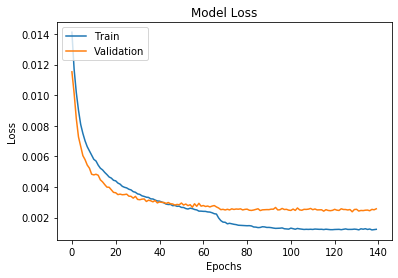

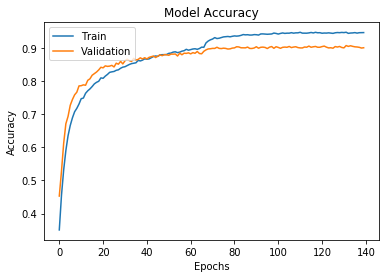

In [0]:
import matplotlib.pyplot as plt

legend = ['Train', 'Validation']
plt.plot(loss_hist)
plt.plot(loss_hist_val)
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(legend, loc='upper left')
plt.show()

legend = ['Train', 'Validation']
plt.plot(acc_hist)
plt.plot(acc_hist_val)
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(legend, loc='upper left')
plt.show()

## Save the trained model

In [0]:
from google.colab import files

torch.save(net.state_dict(), 'checkpoint.pth')
# download checkpoint file
files.download('checkpoint.pth')

In [0]:
net.load_state_dict(torch.load('checkpoint.pth'))

<All keys matched successfully>

## Testing

In [0]:
pred_vec = []
correct = 0
net.eval()
with torch.no_grad():
    for data in test_loader:
        batch, labels = data
        batch, labels = batch.to(device), labels.to(device)
        outputs = net(batch)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        pred_vec.append(predicted)
    pred_vec = torch.cat(pred_vec)

print('Accuracy on the 10000 test images: %.2f %%' % (100 * correct / len(test_set)))

Accuracy on the 10000 test images: 90.22 %


## Visualize wrongly classified image for each class

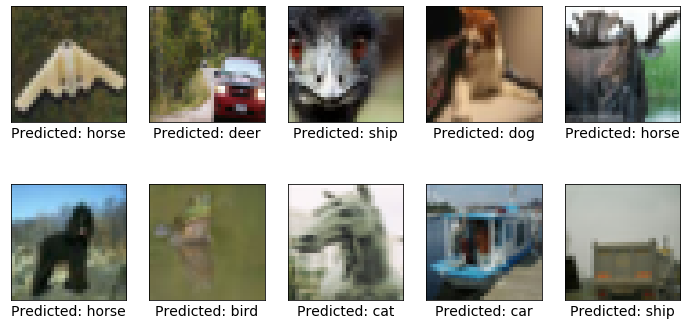

In [0]:
import numpy as np

# visualize wrongly classified image for each class
pred_vec = pred_vec.cpu().numpy()
ground_truths = np.asarray(test_set.targets)
incorrect_mask = pred_vec != ground_truths
incorrect_images = [test_set.data[(ground_truths == label) & incorrect_mask][0] for label in range(10)]
pred_results = [pred_vec[(ground_truths == label) & incorrect_mask][0] for label in range(10)]

# show images
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
i = 0
for row in axes:
    for axis in row:
        axis.set_xticks([])
        axis.set_yticks([])
        axis.set_xlabel("Predicted: %s" % classes[pred_results[i]], fontsize=14)
        axis.imshow(incorrect_images[i])
        i += 1